# Supernovae Ia in catSim

There are three files in catSim that currently provide the SN functionality. This functionality is based on classes provided by 
the python package SNCosmo, through the sncosmo.Model class which is built on top of a sncosmo.source class which describes a transient source in its rest frame in terms of a time series of spectra. The three files added into catSim are:

1. snObject.py: Contains the class SNObject which inherits from the sncsomo.Model class with some decisions appropriate for our use
2. snUniverse.py: Contains definitions of the rates and distribution of types of snObject 
3. sncat.py : How to interact with catSim, get the information there and write things out.

In [1]:
import sniacatalogs as snia

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [3]:
#seaborn Comment out if this is not installed
import seaborn as sns
sns.set()

## snObject : SNObject

The basic idea of this module is to contain classes that represent SN. Right now, we only have one such object representing a 
SNIa based on the SALT model, but later we could expand this to accomodate other objects.

<b>Main thing SNObject is supposed to provide </b> SNObject provides the SED from the SN, extincted through MW dust, as well as convenient methods to obtain band fluxes and magnitudes calling sims.photUtils methods.

To instantiate an SNObject, we have a few alternativaes with different use cases in mind

In [4]:
# Give it an ra, dec
# sims.photUtils uses O'Donnell 94 to calculate extinction, and does not use any other fits. So, the fit function is not 
# a parameter at present
# Following catsim conventions the entries are in degrees
SNObjectfull  = snia.snObject.SNObject(ra=30., dec=60.)

In [5]:
SNObjectfull.setCoords(ra=30., dec=60.)

In [6]:
# The coordinates are stored in radians, but these are not 'public' variables
print 'ra, dec: ',  SNObjectfull._ra , SNObjectfull._dec

ra, dec:  0.523598775598 1.0471975512


In [7]:
# Publicly accessed variables having ra and dec in an array, in the form required by catsim

SNObjectfull.skycoord

array([[ 0.52359878],
       [ 1.04719755]])

In [8]:
# The color excess has been calculated
print 'E(B-V) = ', SNObjectfull.ebvofMW

E(B-V) =  0.977767825127


Obtaining the Sed Object is the crux of this module.

In [9]:
sed = SNObjectfull.SNObjectSED(time=0., wavelen=np.arange(300., 700.,10.))
print sed.wavelen
print sed.flambda

[ 300.  310.  320.  330.  340.  350.  360.  370.  380.  390.  400.  410.
  420.  430.  440.  450.  460.  470.  480.  490.  500.  510.  520.  530.
  540.  550.  560.  570.  580.  590.  600.  610.  620.  630.  640.  650.
  660.  670.  680.  690.]
[  9.03091117e-15   1.33796344e-14   1.53838655e-14   1.68316500e-14
   2.45698825e-14   3.88739192e-14   5.48196813e-14   3.52104127e-14
   3.70689597e-14   8.71962689e-14   8.43299467e-14   1.03487911e-13
   8.92399147e-14   6.12776098e-14   8.21115727e-14   1.07916032e-13
   1.09207281e-13   8.82019759e-14   8.41670020e-14   8.12725843e-14
   8.87362652e-14   1.25898919e-13   1.30130187e-13   9.71921085e-14
   1.10113912e-13   1.18833675e-13   1.51116090e-13   1.49048492e-13
   1.45713590e-13   1.59780169e-13   1.48076355e-13   7.24648555e-14
   1.13911620e-13   1.59077378e-13   1.56878599e-13   1.39914059e-13
   1.30341282e-13   1.17762470e-13   1.11228018e-13   1.02795000e-13]


### Another way to Instantiate the SNObject

In [10]:
SN = snia.snObject.SNObject()
print 'ra, dec: ',  SN._ra , SN._dec
# The color excess has been calculated
print 'E(B-V) = ', SN.ebvofMW

ra, dec:  None None
E(B-V) =  None


But a `None` type color excess precludes any calculations that may require it. You will not be able to request the SED, the magnitudes or fluxes calculated in any filter bands. Calling such a function will tell you what the problem is and suggest how you may fix it. (<b>So the following line is supposed to fail</b>)

In [11]:
print SN.SNObjectSED(time=0., wavelen=np.arange(300., 800., 10.))

ValueError: ebvofMW attribute cannot be None Type and must be set using either ra, dec or by                              hand using set_MWebv before this stage 


One reason this is around, is that sometimes I want to get rid of differences that may arise from extinction, and set these things by hand. For example, I may wish to check something without any extinction! Anyway, following the hint above, the user
should check out the function set_MWebv:

In [12]:
help(SN.set_MWebv)

Help on method set_MWebv in module sniacatalogs.snObject:

set_MWebv(self, value) method of sniacatalogs.snObject.SNObject instance
    if mwebv value is known, this can be used to set the attribute
    ebvofMW of the SNObject class to the value (float).
    
    Parameters
    ----------
    value: float, mandatory
           value of mw extinction parameter E(B-V) in mags to be used in
           applying extinction to the SNObject spectrum
    
    Returns
    -------
    None
    
    Examples
    --------
    >>> t = SNObject()
    >>> t.set_MWebv(0.)
    >>> 0.
    
    .. note:: For a large set of SN, one may use fast `np.ndarray` valued
              functions to obtain an array of such values, and then set
              the values from such an array.



In [13]:
SN.set_MWebv(0.)
# in this case, you could have changed this by setting SN.ebvofMW = 0., 
# but will usually do not allow that sort of thing

In [14]:
print SN.SNObjectSED(time=[0.], wavelen=np.arange(300., 800., 10.))

But ...

In [15]:
print 'ra, dec: ',  SN._ra , SN._dec

ra, dec:  None None


The other feature is that we can change this along the way. So we may instantiate SNObject with a set of parameters and locations, and then change those to represent a different SN. but that does not automatically change ebv. This allows mistakes,
but I think it is a necessary evil to allow setting different ebvofMW values without changing ra, dec, but we can change this property if this turns out to be difficult. 

In [16]:
SN.setCoords(ra=30., dec=60)
SN.ebvofMW

0.0

So, we have to do 

In [17]:
SN.mwEBVfromMaps()
SN.ebvofMW

0.97776782512664795

<b> Summary </b>
- Either supply ra, dec in instantiation call, and you will get correct SED
- Alternative: instantiate without coordinates, and then either set ebvofMW directly or by using setCoords followed by mweEBVfromMaps()

SNObject also has some attributes that are useful. For example, we need to set the parameters of the SN model. The parameters of the SN model are

- 't0' time of peak
- 'x0' amplitude at the top of the earth's atmosphere
- 'x1' parameter related to stretch of supernovae
- 'c' parameter related to E(B-V) color at peak of model
- 'z' redshift

These may be set by the following syntax or by passing a dictionary. Note that guessing a reasonable 'x0' is difficult. 
Instead, one may set a peak absolute magnitude in a particular rest frame band in a magnitude system and a cosmology

In [18]:
SN.set(z=0.5, x1=0., c =0.)
SN.set_source_peakabsmag(absmag=-19.5, band='bessellb', magsys='AB')

The state of the object can be summarized through the `self.summarize()` function that returns a string. 

In [19]:
print SN.summary()

  SNObject Summary      
Model = 
z = 0.5
c = 0.0
x1 = 0.0
x0 = 1.21612139689e-05
t0 = 0.0
ra = 0.523598775598 in radians 
dec = 1.0471975512 in radians 
MW E(B-V) = 0.977767825127
+++++++++++++++++++++++



In [20]:
from lsst.sims.photUtils import Bandpass
from lsst.sims.photUtils.Photometry import PhotometryBase

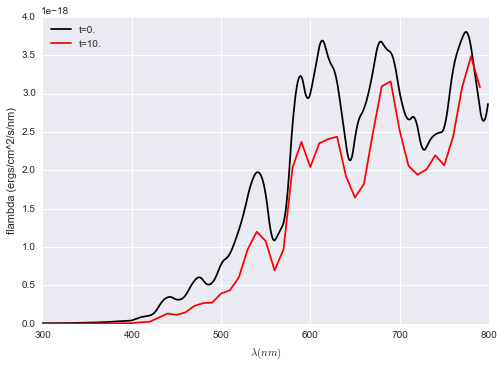

In [21]:
fig, ax = plt.subplots()
sed = SN.SNObjectSED(time=0., wavelen=np.arange(300., 800., 1.))
sed2 = SN.SNObjectSED(time=10., wavelen=np.arange(300., 800., 10.))
ax.plot(sed.wavelen, sed.flambda, 'k-', label='t=0.')
ax.plot(sed2.wavelen, sed2.flambda, 'r-', label='t=10.')
ax.legend(loc='best')
ax.set_xlabel(r'$\lambda (nm)$')
ax.set_ylabel(r'flambda (ergs/cm^2/s/nm)')

Now to get fluxes and magnitudes, we need the bandpasses

In [22]:
# Setup a photUtils class that holds all the LSST bandpasses as a list 
pbase = PhotometryBase()
pbase.loadBandpassesFromFiles()
pbase.setupPhiArray_dict()
# pbase.phiArray

In [23]:
pbase.bandpassDict

OrderedDict([('u', <lsst.sims.photUtils.Bandpass.Bandpass instance at 0x121341200>), ('g', <lsst.sims.photUtils.Bandpass.Bandpass instance at 0x10cca9320>), ('r', <lsst.sims.photUtils.Bandpass.Bandpass instance at 0x1214b6518>), ('i', <lsst.sims.photUtils.Bandpass.Bandpass instance at 0x1214b6878>), ('z', <lsst.sims.photUtils.Bandpass.Bandpass instance at 0x1214b64d0>), ('y', <lsst.sims.photUtils.Bandpass.Bandpass instance at 0x1214b7050>)])

In [24]:
pbase.loadBandpassesFromFiles()

In [25]:
# The following were tried with feature/SIM-1037-only-calculate-requested-magnitudes in photUtils
# Store light curve in fluxes
l = []
for time in np.arange(-20., 50., 1.):
    l.append([time]+ SN.catsimBandFluxes(time=time, bandpassobject=pbase.bandpassDict, phiarray=pbase.phiArray, observedBandPassInds=None).tolist())
# Store light curve in mags    
m = []
for time in np.arange(-20., 50., 1.):
    m.append([time]+ SN.catsimBandMags(time=time, bandpassobject=pbase.bandpassDict, phiarray=pbase.phiArray).tolist())

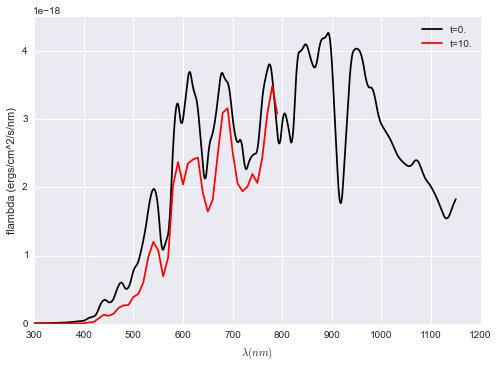

In [26]:
fig, ax = plt.subplots()
sed = SN.SNObjectSED(time=0., bandpassobject=pbase.bandpassDict)
sed2 = SN.SNObjectSED(time=10., wavelen=np.arange(300., 800., 10.))
ax.plot(sed.wavelen, sed.flambda, 'k-', label='t=0.')
ax.plot(sed2.wavelen, sed2.flambda, 'r-', label='t=10.')
ax.legend(loc='best')
ax.set_xlabel(r'$\lambda (nm)$')
ax.set_ylabel(r'flambda (ergs/cm^2/s/nm)')

In [27]:
sed.flambdaTofnu()
sed.manyFluxCalc(phiarray=pbase.phiArray, wavelen_step=pbase.waveLenStep, observedBandPassInd=None)

array([  1.09805840e-09,   5.96125309e-08,   3.54466305e-07,
         5.56399787e-07,   9.12249120e-07,   1.00937312e-06])

In [28]:
pbase.waveLenStep

0.10000000000002274

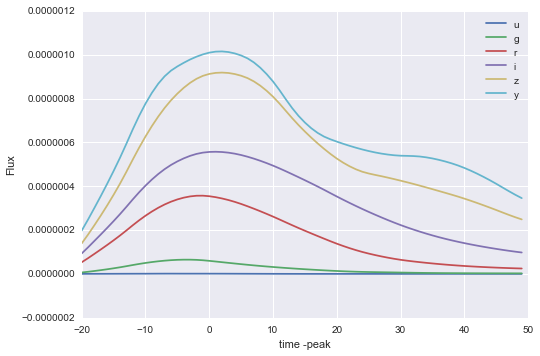

In [29]:
l = np.asarray(l)
fig, ax = plt.subplots()
ax.plot(l[:, 0], l[:, 1], label='u')
ax.plot(l[:, 0], l[:, 2], label='g')
ax.plot(l[:, 0], l[:, 3], label='r')
ax.plot(l[:, 0], l[:, 4], label='i')
ax.plot(l[:, 0], l[:, 5], label='z')
ax.plot(l[:, 0], l[:, 6], label='y')
ax.set_xlabel('time -peak')
ax.set_ylabel('Flux')
ax.legend(loc='best')

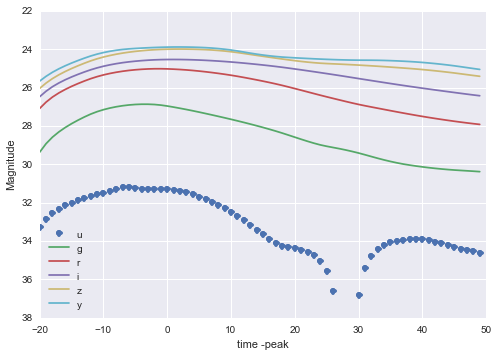

In [30]:
m = np.asarray(m)
fig, ax = plt.subplots()
ax.plot(m[:, 0], m[:, 1], 'o', label='u')
ax.plot(m[:, 0], m[:, 2], label='g')
ax.plot(m[:, 0], m[:, 3], label='r')
ax.plot(m[:, 0], m[:, 4], label='i')
ax.plot(m[:, 0], m[:, 5], label='z')
ax.plot(m[:, 0], m[:, 6], label='y')
ax.invert_yaxis()
ax.set_xlabel('time -peak')
ax.set_ylabel('Magnitude')
ax.legend(loc='best')

Why is the u band light curve funny ? This is a problem with the way the SN models are built. In the training algorithm for SNIa light curves, currently there is no mechanism to enforce positive semidefiniteness on the SN SED. In practice, this does not matter too much, because in the regions of phase space where we have data, the data makes the SED positive definite. It is only in regions where we don't have data (far away from the peak, or at wavelengths closer to the edge of the validity of the model where the observed SN are too dim). In part this is also protected by 'model uncertainties', but there are problems with those as well.

In [31]:
import sncosmo
sdssu = sncosmo.get_bandpass('sdssu')
print 'u band at given redshift has an effective wavelength of ', sdssu.wave_eff/(1 + SN.get('z')),\
' which is too close to the lower wavelength limit of the model'

u band at given redshift has an effective wavelength of  2396.21691127  which is too close to the lower wavelength limit of the model


At these wavelengths, we get negative fluxes!

In [32]:
min(np.asarray(l)[:,1])

-5.1467321855552853e-12

## snUniverse.py: SNUniverse

The basic idea of this module is to contain the distributions and rules of obtaining certain properties of SN. The sort of information that needs to be encoded are  
- What should be the abundance of the types of objects created in SNObject be?
- What should their parameter distributions be like ?

## sncat.py: SNIaCatalog

This inherits from the ` instanceCatalog ` class and uses the functionality in ` CosmologyWrapper ` and `SNUniverse`. This is an `InstanceCatalog` and so provides a catalog of SN observed at a particular exposure.

In [33]:
from lsst.sims.catalogs.generation.db import ObservationMetaData
from sniacatalogs import sncat

In [34]:
from lsst.sims.catalogs.generation.db import CatalogDBObject

First, we create a catalog of all the galaxies in the catalog using the `CatalogDBObject.from_objid` 

In [36]:
galDB = CatalogDBObject.from_objid('galaxyTiled')

/usr/local/manual/anaconda/lib/python2.7/site-packages/sqlalchemy/dialects/mssql/base.py:1294: SAWarning: Did not recognize type 'geography' of column 'geopoint'
  return fn(*arg, **kw)


The catsim framework does not allow us to record these galaxies to disk, but we could by creating an `InstanceCatalog` class. This requires 

In [37]:
from lsst.sims.catalogs.measures.instance import InstanceCatalog
class galCopy(InstanceCatalog):
    column_outputs = ['id', 'raJ2000', 'decJ2000', 'redshift']
    override_formats = {'raJ2000': '%8e', 'decJ2000': '%8e'}

The next step takes a set of mjds and pointings made up here (ie. this should really come from Opsims, but to simplify this notebook, and build a light curve, we will assume that we decided to point at the same location everyday. And to first try out
an instance catalog we can read easily, and understand, we will first do one day.


So, let us instantiate an ObservationMetaData object, and write the catalog associated with it

In [38]:
mjds = [571203.15]
for i, myMJD in enumerate(mjds):
    myObsMD = ObservationMetaData(boundType='circle',
                                  boundLength=0.015,
                                  unrefractedRA=5.0,
                                  unrefractedDec=15.0,
                                  site='LSST',
                                  bandpassName=['u', 'g', 'r', 'i', 'z', 'y'],
                                  mjd=myMJD)
    catalog = sncat.SNIaCatalog(db_obj=galDB, obs_metadata=myObsMD)

In [39]:
gals = galCopy(db_obj=galDB, obs_metadata=myObsMD)
gals.write_catalog('gals.dat')

The SNIaCatalog object has an attribute called `suppressDimSN`. If set to true, it does not add any SN that have peak dates outside a (can be changed) `maxTimeSNVisible` day window surrounding the date of observation. 

In [40]:
catalog.suppressDimSN

True

In [41]:
catalog.maxTimeSNVisible

100.0

In [42]:
catalog.suppressDimSN = False
# Check
print catalog.suppressDimSN

False


Similarly, we have the boolean variable `suppressHighzSN` which when set to `True`, prevents the addition of SN with redshifts higher than `maxz` to the catalog.

In [43]:
print catalog.suppressHighzSN

True


In [44]:
print catalog.maxz

1.2


Now, with the current configuration, the catalog that we write should have as many SN as galaxiex for redshifts below the maximal redshift for SN

In [45]:
catalog.write_catalog('catalog_day.txt', write_metadata=True, meta_key='#@')

In [46]:
import numpy as np

In [47]:
galcat = np.loadtxt('gals.dat', delimiter=',')
sn = np.loadtxt('catalog_day.txt', delimiter=',')

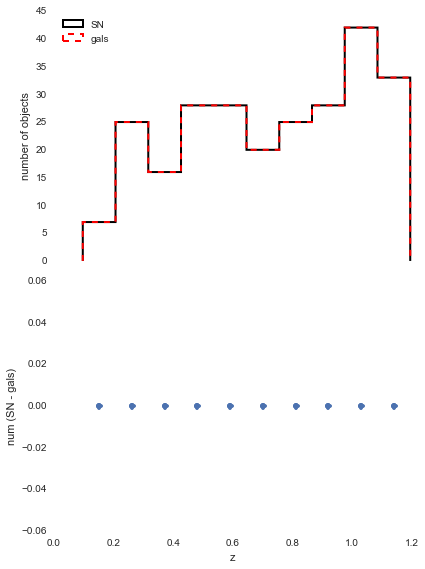

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, figsize=(6, 8), sharex=True)
countssn, bins, patches = ax[0].hist(sn[:, 3], histtype='step', label='SN', lw=2., color='k')
countsgals, bins, patches = ax[0].hist(galcat[:, 3], bins=bins, histtype='step', linestyle='dashed', lw=2.0, color='r', label='gals')
ax[0].set_ylabel('number of objects')
ax[0].legend(loc='upper left')
ax[1].plot((bins[:-1] + bins[1:])/2.0, countsgals - countssn, 'o')
ax[1].set_xlabel('z')
ax[1].set_ylabel('num (SN - gals)')

plt.tight_layout()
fig.set_label('Comparison of galaxy catalog with SN catalog')

This shows that the behavior of the SN catalog is as expected: we get a SN for each galaxy in the region, so long as its redshift is below `catalog.maxz`

In [49]:
catalog.suppressDimSN = True

In [50]:
catalog.write_catalog('SN_TimeWindow.txt')

In [51]:
!head SN_TimeWindow.txt

#snid, snra, sndec, z, t0, c, x1, x0, flux_u, flux_g, flux_r, flux_i, flux_z, flux_y, mag_u, mag_g, mag_r, mag_i, mag_z, mag_y
1426829, 8.723553e-02, 2.618648e-01, 0.9604, 571181.4041, 1.178580e-01, 0.8889, 1.828948e-06, 6.921282e-11, -2.291597e-09, 5.895654e-08, 3.046362e-07, 4.852002e-07, 4.813532e-07, 34.2996, nan, 26.9737, 25.1906, 24.6853, 24.6939


This shows that once we turn on the `suppressDimSN` boolean, we filter out an overwhelming number of SN compared to the number of galaxies. This is expected, and this shows that it works.

## Building Light Curves from Instance Catalogs

We would like to create a number of supernova instance catalogs and then build the light curves from the catalogs. To do this correctly, we would like to use the `observation_metadata` associated with a number of conscutive OpSIM pointings. Right now, though, it will be nice to demonstrate that we are getting light curves from a number of instance catalogs, without caring about a particular strategy. Hence, we will create a 20 epoch list of `observation_metadata` , where we 'observe' in all bands, and quickly by doing a small field of view (0.015 degree). 

In [52]:

import lightcurve_utils as lu

In [53]:
#This creates a list of obsMetaData with a starting point, a cadence and a total number of epochs
def obsMetaDataList(startdate=570180, cadence=3.0, numepochs=20):
    """
    create a list of obsMetaData variables for a list of pointings.


    Parameters
    ----------
    startdate: float, optional, defaults to 570180
        starting date of sequence
    cadence: float, optional, defaults to 3.0
        interval between epochs of observations
    numepochs: int, optional, defaults to 20
        number of epochs of observations


    Returns
    -------
    list of `~lsst.sims.catalogs.generation.db.ObservationMetaData` variables


    .. note: This will finally come from OpSims output, this is just a mock up.
    """

    # List of MJDs with a three day cadence with 20 epochs
    myMJDS = [startdate + cadence*i for i in range(numepochs)]
    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    unrefRA = 5.0
    unrefDec = 15.0
    boundLen = 0.015
    boundType = 'circle'

    obsMetaDataList = []
    for mjd in myMJDS:
        obsMetaDataList.append(ObservationMetaData(boundType=boundType,
                               unrefractedRA=unrefRA,
                               unrefractedDec=unrefDec,
                               boundLength=boundLen,
                               bandpassName=filters,
                               mjd=mjd))
    return obsMetaDataList

In [54]:
obsMDList = obsMetaDataList()

In [55]:
obsMDList[0].summary

{'bandpass': ['u', 'g', 'r', 'i', 'z', 'y'],
 'boundLength': 0.00026179938779914941,
 'boundType': 'circle',
 'mjd': 570180.0,
 'phoSimMetadata': None,
 'rotSkyPos': 0.0,
 'skyBrightness': None,
 'unrefractedDec': 0.26179938779914941,
 'unrefractedRA': 0.087266462599716474}

In [56]:
obsMDList[1].summary

{'bandpass': ['u', 'g', 'r', 'i', 'z', 'y'],
 'boundLength': 0.00026179938779914941,
 'boundType': 'circle',
 'mjd': 570183.0,
 'phoSimMetadata': None,
 'rotSkyPos': 0.0,
 'skyBrightness': None,
 'unrefractedDec': 0.26179938779914941,
 'unrefractedRA': 0.087266462599716474}

We now want to write the light curves to a database. The way this function actually works is it creates the instance catalogs 
for each of the obs_metadata points, writes them to disk using the `InstanceCatalog.write_catalog` method, reads the files from disk (right now the filenames are chosen in the same order as obs_metadata objects), and writes them to a sqlite database.

In [ ]:
if not os.path.exists('data/LightCurves'): 
    os.makedirs('data/LightCurves')

In [ ]:
lu.writeCatalogtoDB(dbfile='data/sncat_new.db', dbtable='mysncat', ascii_root='data/SNIa_new_', galdb=galDB, obsMetaDataList=obsMDList)
    

deleting previous database
0 <type 'list'> 570180.0
1 <type 'list'> 570183.0

The following function then queries the database, and groups the data by a SNID number to build the light curves.

In [ ]:
lcs = lu.getLCsFromDB(dbfile='data/sncat_new.db',
                 dbtable='mysncat',
                 lc_root='data/LightCurves/SN_new_')

We can check how many light curves are there, and we can display each light curve in the following way

In [ ]:
len(lcs)

In [ ]:
lcs[1][1]

In this case, we have light curves associated with two different objects, and we can now plot them.

In [ ]:
fig, ax = plt.subplots(figsize=(24,8))
lu.plotlc(lcs[0])
lu.plotlc(lcs[1], marker='s')
ax.invert_yaxis()

The circles and squares are two different SN which were in lcs. The colors represent the different bands.